In [1]:
import os
import random
import numpy as np
import scanpy as sc
import anndata as ad

import torch
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

import NEXUS
from NEXUS.data_process.data_preprocess_cell import Data_process
from NEXUS.cell_emb.model import OneViewVAE, train_model, test_model, embedding, loss_function_oneview, TwoViewVAE, loss_function_twoview

In [2]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [3]:
input_file_path = "../test_data/test.h5ad"
output_path = "../test_data/1_cell_emb_output/"
num_of_highly_variable_genes = 5579
split_ratio = 0.8
batch_size = 4096
cell_embedding_dim = 64
device_use = "cpu"
view = "oneview"

In [4]:
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

In [5]:
data_process = Data_process(input_file_path, num_of_highly_variable_genes, split_ratio, batch_size, device_use, process=False)
device = data_process.setup_DDP()

In [6]:
if data_process.use_ddp:
    data_process.read_all_adata()
    if dist.get_rank() == 0:
        meta_train, meta_test = data_process.train_test_split()
        import pickle
        train_indices = meta_train.obs.index.tolist()
        test_indices = meta_test.obs.index.tolist()
        with open(output_path + 'temp_train_test_indices.pkl', 'wb') as f:
            pickle.dump((train_indices, test_indices), f)
    dist.barrier()
    if dist.get_rank() != 0:
        import pickle
        with open(output_path + 'temp_train_test_indices.pkl', 'rb') as f:
            train_indices, test_indices = pickle.load(f)
        meta_train = data_process.combined_adata[train_indices].copy()
        meta_test = data_process.combined_adata[test_indices].copy()
    dist.barrier()
    if dist.get_rank() == 0:
        if os.path.exists(output_path + 'temp_train_test_indices.pkl'):
            os.remove(output_path + 'temp_train_test_indices.pkl')
else:
    data_process.read_all_adata()
    meta_train, meta_test = data_process.train_test_split()

In [7]:
train, test, train_iter, test_iter, train_iter_emb, test_iter_emb, sampler_train, sampler_test = data_process.data_sampler(meta_train, meta_test)

In [8]:
if view == "oneview":
    model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)
    loss_function=loss_function_oneview
elif view == "twoview":
    model = TwoViewVAE(num_of_highly_variable_genes, cell_embedding_dim, method = "gaussian")
    loss_function=loss_function_twoview
model = model.to(device)

if data_process.use_ddp:
    model = DDP(model)
    print("Model wrapped with DDP")
else:
    print("Model running in single GPU/CPU mode (no DDP)")

Model wrapped with DDP


In [9]:
model = train_model(model, train_iter, test_iter, sampler_train, loss_function, device)
print(f'Training finished')

Epoch 1/500
Train Loss: 0.4570 | Test Loss: 0.2699
Updated best model, current best validation loss: 0.2699
Epoch 2/500
Train Loss: 0.2437 | Test Loss: 0.2191
Updated best model, current best validation loss: 0.2191
Epoch 3/500
Train Loss: 0.2053 | Test Loss: 0.1893
Updated best model, current best validation loss: 0.1893
Epoch 4/500
Train Loss: 0.1776 | Test Loss: 0.1667
Updated best model, current best validation loss: 0.1667
Epoch 5/500
Train Loss: 0.1603 | Test Loss: 0.1544
Updated best model, current best validation loss: 0.1544
Epoch 6/500
Train Loss: 0.1475 | Test Loss: 0.1426
Updated best model, current best validation loss: 0.1426
Epoch 7/500
Train Loss: 0.1376 | Test Loss: 0.1343
Updated best model, current best validation loss: 0.1343
Epoch 8/500
Train Loss: 0.1287 | Test Loss: 0.1258
Updated best model, current best validation loss: 0.1258
Epoch 9/500
Train Loss: 0.1214 | Test Loss: 0.1194
Updated best model, current best validation loss: 0.1194
Epoch 10/500
Train Loss: 0.1

In [10]:
is_main_process = True
if data_process.use_ddp:
    is_main_process = (dist.get_rank() == 0)
    if is_main_process:
        torch.save(model.module, output_path + "VAE.pth")
        print(f"Save done!")
    dist.barrier()
    dist.destroy_process_group()
else:
    torch.save(model, output_path + "VAE.pth")
    print(f"Save done!")

Save done!


In [11]:
if is_main_process:
    device = torch.device("cuda:0")
    
    if view == "oneview":
        model = OneViewVAE(num_of_highly_variable_genes, cell_embedding_dim)
    elif view == "twoview":
        model = TwoViewVAE(num_of_highly_variable_genes, cell_embedding_dim, method = "gaussian")
    checkpoint = torch.load(output_path + "VAE.pth", map_location=torch.device('cpu'), weights_only=False)
    model.load_state_dict(checkpoint.state_dict())
    
    adata_test_raw, _ = embedding(model, test_iter_emb, test, view)
    adata_train_raw, _ = embedding(model, train_iter_emb, train, view)
    adata_test_raw.obs = meta_test.obs
    adata_train_raw.obs = meta_train.obs
    
    adata_all_raw = ad.concat({'train': adata_train_raw, 'test':adata_test_raw}, label = 'train_test')
    adata_all_raw.write(output_path + 'VAE_embedded.h5ad')
    print(f'Embedding finished')

Embedding finished


In [12]:
import scanpy as sc
import NEXUS
from NEXUS.plotting.emb_plot import cell_embedding_umap_plot

In [13]:
output_path = "../test_data/1_cell_emb_output/"
adata_emb = sc.read_h5ad(output_path + 'VAE_embedded.h5ad')
batch = "sample_ID"
label = "cell_type"

E:\NEXUS\NEXUS\plotting\emb_plot.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)


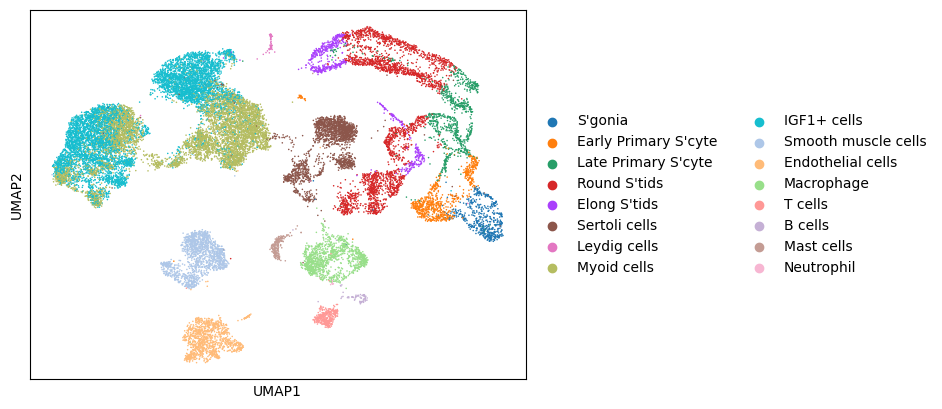

2026-01-15 16:54:36,787 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2026-01-15 16:54:43,413 - harmonypy - INFO - sklearn.KMeans initialization complete.
2026-01-15 16:54:43,625 - harmonypy - INFO - Iteration 1 of 10
2026-01-15 16:54:53,874 - harmonypy - INFO - Iteration 2 of 10
2026-01-15 16:55:04,791 - harmonypy - INFO - Iteration 3 of 10
2026-01-15 16:55:15,745 - harmonypy - INFO - Iteration 4 of 10
2026-01-15 16:55:27,309 - harmonypy - INFO - Iteration 5 of 10
2026-01-15 16:55:38,742 - harmonypy - INFO - Converged after 5 iterations


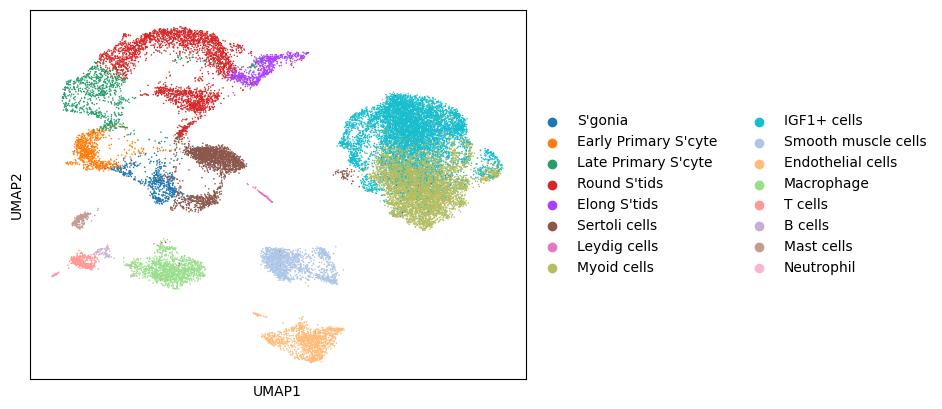

In [14]:
adata_umap = cell_embedding_umap_plot(adata_emb, label, batch, harm = True)

In [15]:
adata_umap.write(output_path + 'VAE_embedded.h5ad')